In [1]:
%%time
import pandas as pd
import re, string, unicodedata
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.pylab as pylab
%matplotlib inline
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
print(__version__) # requires version >= 1.9.0
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

import plotly.graph_objs as go
import plotly.express as px
import qgrid

from ast import literal_eval
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA

from keras.layers import Dropout, Dense, Activation,Input,Embedding,Flatten, AveragePooling2D, Conv2D,Reshape, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, LSTM
from keras.models import Sequential,Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import Concatenate
from gensim.models import Word2Vec, KeyedVectors

import gensim 
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk import word_tokenize

print('pandas version', pd.__version__)

5.1.0


pandas version 1.2.4
Wall time: 14 s


# Step 1: Get Raw Data

In [ ]:
def row_count(input):
    with open(input) as f:
        for i, l in enumerate(f):
            pass
    return i

print('lines:', row_count('ams__cargodesc_2018__202001290000.csv'))
print('lines:', row_count('ams__tariff_2018__202001290000.csv'))

In [ ]:
# read chunk by chunk so as not to run out of memory... 
# for each chunk, append to merged.csv after trying to drop as much unnecessary information as possible
hs18 = pd.read_csv('ams__tariff_2018__202001290000.csv',low_memory=False)
desc18 = pd.read_csv('ams__cargodesc_2018__202001290000.csv',low_memory=False, chunksize=1000000)

for i, chunk in enumerate(desc18):
  df = chunk.merge(hs18, how='inner', left_on=["description_sequence_number","identifier", "container_number"], right_on=["description_sequence_number","identifier","container_number"])
  df = df.drop('identifier', axis=1)
  df = df.drop('container_number', axis=1)
  df = df.drop('description_sequence_number', axis=1)
  df = df.drop('piece_count', axis=1)
  df = df.drop('harmonized_value', axis=1)
  df = df.drop('harmonized_weight', axis=1)
  df = df.drop('harmonized_weight_unit', axis=1)
  df = df.drop_duplicates()
  df = df.dropna()
  df.to_csv('merged.csv', mode='a', index=False)

In [ ]:
df = pd.read_csv('merged.csv')
#drop the duplicates
df = df.drop_duplicates()

#drop missing values
df = df.dropna()

df['harmonized_number'] = df['harmonized_number'].apply(lambda x: str(x).replace(' ',''))

#remove corrupted HS codes
df['harmonized_number'].apply(lambda x: re.sub('[^0-9]','',x))

#drop HS-2 and HS-4
mask = (df['harmonized_number'].str.len() >= 6)
df = df.loc[mask]

#convert HTS to HS-6
df['harmonized_number'] = df['harmonized_number'].apply(lambda x: x[:6])

#drop first entries
df.drop_duplicates(subset ="description_text", 
                     keep = 'first', inplace = True)

df = df.reset_index()
df = df.drop(['index'],axis=1)

df.info()
df.to_csv('step1_input_raw.csv', index=False)


# Step 2: Process Raw Data
Steps: 
- Analyze Distribution of HS Codes and Input Lengths
- Tokenize
- Save into step2_input_tokenized.csv

In [ ]:
df = pd.read_csv('step1_input_raw.csv',low_memory=False)
df.info()
df.head()

In [ ]:
df['harmonized_number'] = df['harmonized_number']
df.describe(include=np.object).transpose()
df.head(5)

In [ ]:
hs_dist = df.groupby('harmonized_number').count()
hs_dist.describe()

In [ ]:
layout = go.Layout(xaxis_title="HS codes", yaxis_title="Count", xaxis=dict(type='category'))
fig = hs_dist.iplot(kind = 'line', bins = 4001,layout=layout)

In [ ]:
desc_dist = df['description_text'].str.len()
desc_dist.describe().apply(lambda x: format(x, 'f'))

In [ ]:
fig = px.histogram(desc_dist, x='description_text',nbins=50,labels={'description_text':'Description length in symbols'})
fig.show()

In [ ]:
df['description_text'] = df['description_text'].apply(word_tokenize)

vocab = set([])
df['description_text'].apply(lambda x: vocab.update(x))
len(vocab)
df.head(5)

In [ ]:
wordcount = []
df['description_text'].apply(lambda x: wordcount.append(len(x)))
sum(wordcount)

In [ ]:
df['description_text_len'] = df['description_text'].apply(lambda x: len(x))
df['description_text_len']
df.head(50)

In [ ]:
df['description_text_len'].describe().apply(lambda x: format(x, 'f'))

In [ ]:
fig = px.histogram(df['description_text_len'], x='description_text_len',nbins=50, labels={'description_text_len':'Description length in words'})
fig.update_traces(marker_color='red')
fig.show()

In [ ]:
if 'description_text_len' in df.columns:
  print('description_text_len column dropped')
  df = df.drop('description_text_len', axis=1)
print(df.head(5))

In [ ]:
df.to_csv('step2_input_tokenized.csv', index=False)

# Step 3: Cleansing
- Cleanse each row, save into step3_input_lemmatized.csv
- See the statistics again

In [ ]:
df = pd.read_csv('step2_input_tokenized.csv',low_memory=False)
df['description_text'] = df.description_text.apply(literal_eval)
df.info()
df.head()

In [ ]:
ignore = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 
          'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 
          'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
          "that'll", 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
          'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 
          'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
          'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
          'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
        'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're',
           've', 'y', 'ain', 'aren', "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hand't", "hasn", "hasn't",
          "haven", "haven't", "isn", "isn't", "ma", "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", "shouldn", 
          "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn", "wouldn't"]

noise = ['hs','code','hts','invoice','pallet','kg','certify','po','pack','industry','office','expiration',
                'voyage','cargo','clearance','date','onto','loading', 'de', 'appliance','en','ca','un',
                'freight','package', 'load','shipper','qty', 'net','contain','container','order','number',
                'weight','contract','carrier','shipment','dhl', 'notify','collect','shipper','certified',
                'pc','forwarding','delivery','note', 'ref', 'packed', 'gross','product','loaded',
                'piece','export','of','and','no','po','on','for','nw','number','article','classification',
                'tariff','china','brazil','argentine','date','new','unpacked','limited','traffic','pay',
                'ctn','nr','no','name','am','serial','ex','exceed','payable','regulate','fi','exclude',
                'blk','gr','international','fca','due','eta','etd','accordance','deliver',
                'stc','gross','order','pcs','total','per','the','prepaid','consist','distribution',
                'plt','contain','equipment','capacity','class','white','description','approve',
                'shipped','nos','ncm','tariff','category','ready','license','violation',
                'country','count','nesoi','ncm','ruc','complete','id','quantity','regulation',
                'destination','nac','pkg','declare','declared','fax','cargo','transportation',
                'commercial','contact','nvocc','nbr', 'prepaid','brand','continuation',
                'hc','mm','customer','orange','violet','rose','company',
                'imo','sc','tsca','cm','hscode','harmless','applicable',
                'po','ship','nw','y','pkg', 'esd','email','sc','pack','detail','transport',
                'banq','origin','pa','charge','account','via',
                'rate', 'package','certify','container', 'consignee','declare',
                'purchase','payment','bill','abroad','express','certify',
                'red','green','black','grey','blue','yellow','white','account','charge','local',
                'date','id','name','item','customer','lot','duty','invoice','commodity',
                'address','comply','say','mexico','canada','japan','uk','germany','france',
                'shipping','exporter', "import", "information", "declaration",'supplier','release',
                'loader','agreement','liability','compliant', 'registration','compliance','weigh',
                'foreign', 'corporation','discharge','certificate','detention','logistics','vessel',
                'transit','temperature','quality','transfer','impact','requirement','global','tax','reception',
                'manufacturer','carriage','enterprise','trading','emergency','free','description','agreement','terminal',
                'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
                ]

english = set(nltk.corpus.words.words())

tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

lemmatizer = WordNetLemmatizer()

def remove_noise(words):
    """Remove noise from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in noise:
            new_words.append(word)
    return new_words

def remove_non_english(words):
    """Remove non english words in list of tokenized words"""
    new_words = []
    for word in words:
        if word in english:
            new_words.append(word)
    return new_words

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, get_wordnet_pos(word))
        lemmas.append(lemma)
    return lemmas

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in ignore:
            new_words.append(word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def word_to_num(words):
    """Convert all textual numbers to digits from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word
        try:
            new_word = str(w2n.word_to_num(word))
        except:
            pass
        new_words.append(new_word)
    return new_words

def remove_non_alpha(words):
    """Remove non alpha in list of tokenized words"""
    new_words = []
    for word in words:
        if word.isalpha():
            new_words.append(word)
    return new_words

In [ ]:
%%time
df['description_text'] = df['description_text'].apply(to_lowercase)\
                        .apply(remove_non_ascii).apply(word_to_num).apply(remove_non_alpha).apply(remove_stopwords)\
                        .apply(remove_punctuation).apply(remove_non_english).apply(remove_noise).apply(lemmatize)
df.head(150)

In [ ]:
df = df[df['description_text'].map(lambda d: len(d)) > 0]

df = df.reset_index()
df = df.drop(['index'],axis=1)

df.to_csv('step3_input_lemmatized.csv', index=False)
df.info()
df.head(5)

In [ ]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: set(x))
df['description_text'] = df['description_text'].apply(sorted)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

df.info()
df.head()

In [ ]:
df['harmonized_number'] = df['harmonized_number'].astype(str)
df.describe(include=np.object).transpose()


In [ ]:
hs_dist = df.groupby('harmonized_number').count()
hs_dist.describe()

In [ ]:
layout = go.Layout(xaxis_title="HS codes", yaxis_title="Count", xaxis=dict(type='category'))
fig = hs_dist.iplot(kind = 'line', bins = 4119,layout=layout)

In [ ]:
desc_dist = df['description_text'].str.len()
desc_dist.describe().apply(lambda x: format(x, 'f'))

In [ ]:
import plotly.express as px
fig = px.histogram(desc_dist, x='description_text',nbins=50,labels={'description_text':'Description length in symbols'})
fig.show()

In [ ]:
vocab = set([])
df['description_text'].apply(lambda x: vocab.update(x))
print(len(vocab))
print(vocab)

In [ ]:
wordcount = []
df['description_text'].apply(lambda x: wordcount.append(len(x)))
sum(wordcount)

In [ ]:
df['description_text'] = df['description_text'].apply(lambda x: len(x))
df['description_text'].describe().apply(lambda x: format(x, 'f'))

In [ ]:
fig = px.histogram(df['description_text'], x='description_text',nbins=50, labels={'description_text':'Description length in words'})
fig.update_traces(marker_color='red')
fig.show()

# Step 4: Splitting data to train and test

In [ ]:
df = pd.read_csv('step3_input_lemmatized.csv', dtype=object, low_memory=False)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

df.info()
df.head()

In [ ]:
hs_dist = df.groupby('harmonized_number').count()
hs_dist.describe()

In [ ]:


X = df['description_text']
y = df['harmonized_number']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777,stratify=y)

len(y_test.unique())

In [ ]:
train_df = pd.DataFrame({'description_text':X_train, 'harmonized_number':y_train})
test_df = pd.DataFrame({'description_text':X_test, 'harmonized_number':y_test})
train = train_df.groupby('harmonized_number').count()
test = test_df.groupby('harmonized_number').count()

In [ ]:
layout = go.Layout(xaxis_title="Train data", yaxis_title="Count", xaxis=dict(type='category'))
fig = train.iplot(kind = 'line', bins = 3243,layout=layout)

In [ ]:
layout = go.Layout(xaxis_title="Test data", yaxis_title="Count", xaxis=dict(type='category'))
fig = test.iplot(kind = 'line', bins = 3243,layout=layout)

In [ ]:
print('Length of train data:', len(X_train))
print('Length of test data:',len(X_test))

# Step 5: Feature Extraction
- Input: step3_input_lemmatized.csv

In [35]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False)
df['description_text'] = df.description_text.apply(literal_eval)
data = df['description_text']

In [36]:
#CBOW sg is 0 by default
model = gensim.models.Word2Vec(data, min_count = 1,  
                              vector_size = 100, window=5, epochs=20)

model.wv.save("word2vec_lemmatized_cbow.kv")

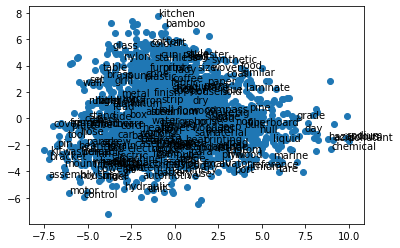

Wall time: 2.26 s


In [37]:
%%time
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index)
for i, word in enumerate(words[:200]):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()

In [38]:
%%time
model = gensim.models.Word2Vec(data, min_count = 1,  
                              vector_size=100, window = 5, sg = 1, epochs= 20)

model.wv.save("word2vec_lemmatized_skipgram.kv")

Wall time: 52.6 s


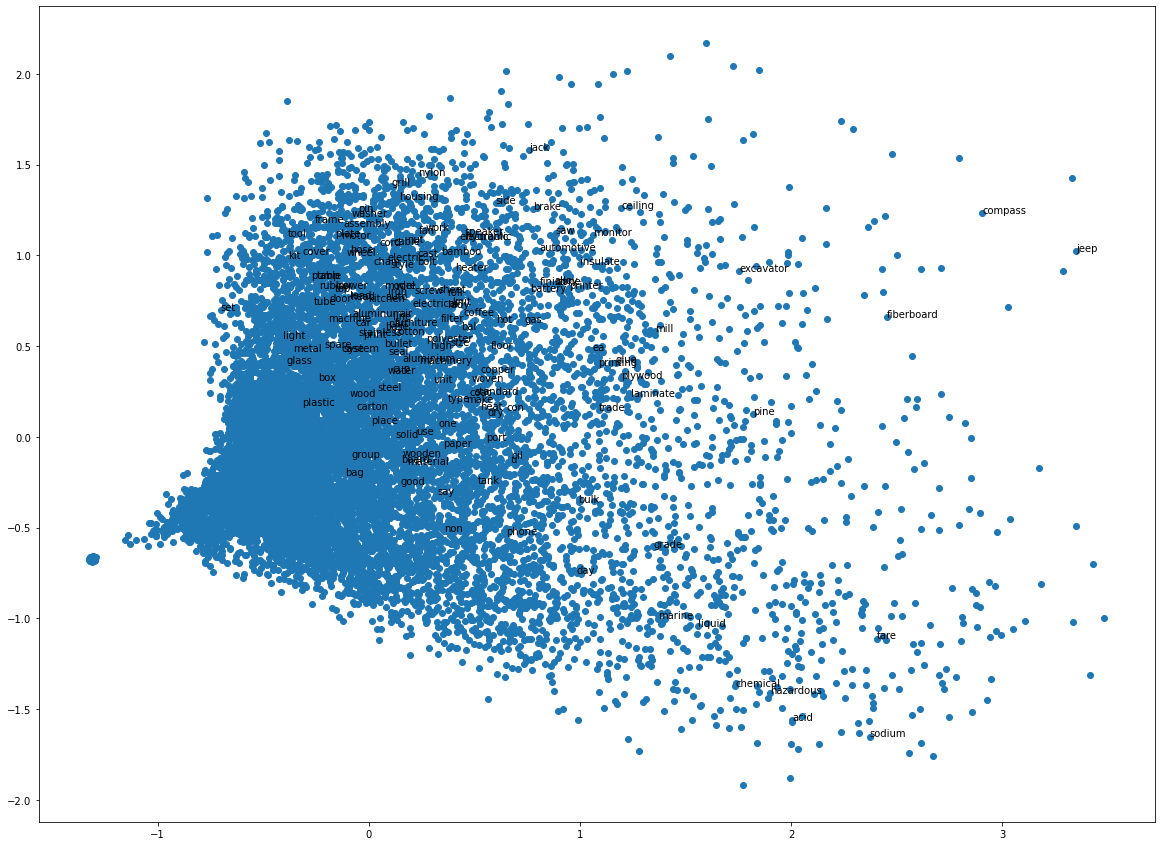

Wall time: 1.72 s


In [39]:
%%time
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index)
for i, word in enumerate(words[:150]):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()

In [ ]:
'''
%%time
#PV-DM dm = 1 PV-DBOW dm = 0
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')
data = df['description_text']

tagged_data = [TaggedDocument(words=word_tokenize(str(_d).lower()), tags=[str(i)]) for i, _d in enumerate(data)]

max_epochs = 20
vec_size = 100
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("doc2vec_lemmatized_pv_dm.bin")
model.wv.save("doc2vec_lemmatized_pv_dm.kv")
'''

In [ ]:
'''
%%time
vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.key_to_index)
for i, word in enumerate(words[:100]):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.rcParams["figure.figsize"] = (20,15)
pyplot.show()
'''

# Step 6 - Classification Attempts Using Various Algorithms

## 6.1 K-NN

In [5]:
%%time

df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False, nrows=10000)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

X = df["description_text"]
y = df["harmonized_number"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777)
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier()),
                     ])

text_clf.fit(X_train, y_train)

predicted = text_clf.predict(X_test)


import pickle
knn_model_filename = 'model_knn.sav'
pickle.dump(text_clf, open(knn_model_filename, 'wb'))

print(metrics.classification_report(y_test, predicted))

<timed exec>:11: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



              precision    recall  f1-score   support

       89910       0.50      1.00      0.67         2
       89999       0.00      0.00      0.00         1
      121189       0.33      1.00      0.50         1
      121229       0.00      0.00      0.00         2
      124919       0.00      0.00      0.00         0
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.18      0.75      0.29         4
      151410       0.00      0.00      0.00         2
      151419       0.17      0.50      0.25         2
      151529       0.00      0.00      0.00         1
      151743       0.00      0.00      0.00         1
      151798       0.00      0.00      0.00         0
      153299       0.00      0.00      0.00         0
      169957       0.00      0.00      0.00         1
      229919       0.00      0.00      0.00         0
      251511       0.00      0.00      0.00         1
      251512       0.07    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

In [6]:
X_test.head(10)

1301                    home furnish home furnish
4999                                        laser
962                 alloy steel alloy steel rough
5197                           hydraulic cylinder
6267    st st liner select toolbox dry erase tape
4162                                   fifth good
8602                            axial fan blow er
5935                                        truck
5721                               men woven pant
7707                                    pro power
Name: description_text, dtype: object

In [7]:
predicted

array([291220, 844332, 731815, ..., 291220, 291220, 731815], dtype=int64)

In [8]:
knn_loaded_model = pickle.load(open(knn_model_filename, 'rb'))
predicted = knn_loaded_model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       89910       0.50      1.00      0.67         2
       89999       0.00      0.00      0.00         1
      121189       0.33      1.00      0.50         1
      121229       0.00      0.00      0.00         2
      124919       0.00      0.00      0.00         0
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.18      0.75      0.29         4
      151410       0.00      0.00      0.00         2
      151419       0.17      0.50      0.25         2
      151529       0.00      0.00      0.00         1
      151743       0.00      0.00      0.00         1
      151798       0.00      0.00      0.00         0
      153299       0.00      0.00      0.00         0
      169957       0.00      0.00      0.00         1
      229919       0.00      0.00      0.00         0
      251511       0.00      0.00      0.00         1
      251512       0.07    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

In [9]:
def knn_predict(input):
  new_series = pd.Series(input)
  return knn_loaded_model.predict(new_series)

print('woodworking machine spare part', knn_predict('woodworking machine spare part'))
print('horse', knn_predict('horse'))

woodworking machine spare part [846591]
horse [291220]


# 6.2 Decision Tree

In [ ]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

X = df["description_text"]
y = df["harmonized_number"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', tree.DecisionTreeClassifier()),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

import pickle
filename = 'model_decision_tree.sav'
pickle.dump(text_clf, open(filename, 'wb'))

print(metrics.classification_report(y_test, predicted))

In [ ]:
decision_tree_loaded_model = pickle.load(open(filename, 'rb'))
predicted = decision_tree_loaded_model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

In [ ]:
def decisiontree_predict(input):
  new_series = pd.Series(input)
  return decision_tree_loaded_model.predict(new_series)

print('woodworking machine spare part', decisiontree_predict('woodworking machine spare part'))
print('horse', decisiontree_predict('horse'))

# 6.3 Random Forest

In [20]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False, nrows=10000)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

X = df["description_text"]
y = df["harmonized_number"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100,max_depth=35)),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))
import pickle
filename = 'model_random_forest.sav'
pickle.dump(text_clf, open(filename, 'wb'))



<ipython-input-20-5d29bd75f91d>:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-pa

              precision    recall  f1-score   support

       89910       0.00      0.00      0.00         2
       89999       0.00      0.00      0.00         1
      121189       0.00      0.00      0.00         1
      121229       0.00      0.00      0.00         2
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.00      0.00      0.00         4
      151410       0.00      0.00      0.00         2
      151419       0.00      0.00      0.00         2
      151529       0.00      0.00      0.00         1
      151743       0.00      0.00      0.00         1
      169957       0.00      0.00      0.00         1
      251511       0.00      0.00      0.00         1
      251512       0.00      0.00      0.00         4
      251612       1.00      1.00      1.00         1
      252320       0.00      0.00      0.00         1
      252321       0.67      1.00      0.80         4
      252921       0.00    

In [21]:
random_forest_loaded_model = pickle.load(open(filename, 'rb'))
predicted = random_forest_loaded_model.predict(X_test)
print(metrics.classification_report(y_test, predicted))


              precision    recall  f1-score   support

       89910       0.00      0.00      0.00         2
       89999       0.00      0.00      0.00         1
      121189       0.00      0.00      0.00         1
      121229       0.00      0.00      0.00         2
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.00      0.00      0.00         4
      151410       0.00      0.00      0.00         2
      151419       0.00      0.00      0.00         2
      151529       0.00      0.00      0.00         1
      151743       0.00      0.00      0.00         1
      169957       0.00      0.00      0.00         1
      251511       0.00      0.00      0.00         1
      251512       0.00      0.00      0.00         4
      251612       1.00      1.00      1.00         1
      252320       0.00      0.00      0.00         1
      252321       0.67      1.00      0.80         4
      252921       0.00    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

# 6.4 SVM

In [24]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False, nrows=10000)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

X = df["description_text"]
y = df["harmonized_number"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LinearSVC()),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

import pickle
filename = 'model_svm.sav'
pickle.dump(text_clf, open(filename, 'wb'))


<ipython-input-24-e1eaa47b816a>:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



              precision    recall  f1-score   support

       89910       0.50      1.00      0.67         2
       89999       0.00      0.00      0.00         1
      121189       1.00      1.00      1.00         1
      121229       0.00      0.00      0.00         2
      124919       0.00      0.00      0.00         0
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.43      0.75      0.55         4
      151410       0.00      0.00      0.00         2
      151419       0.00      0.00      0.00         2
      151529       0.00      0.00      0.00         1
      151743       1.00      1.00      1.00         1
      153299       0.00      0.00      0.00         0
      169957       0.00      0.00      0.00         1
      251511       0.00      0.00      0.00         1
      251512       0.25      0.25      0.25         4
      251610       0.00      0.00      0.00         0
      251612       0.33    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

In [25]:
svm_loaded_model = pickle.load(open(filename, 'rb'))
predicted = svm_loaded_model.predict(X_test)
print(metrics.classification_report(y_test, predicted))


              precision    recall  f1-score   support

       89910       0.50      1.00      0.67         2
       89999       0.00      0.00      0.00         1
      121189       1.00      1.00      1.00         1
      121229       0.00      0.00      0.00         2
      124919       0.00      0.00      0.00         0
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.43      0.75      0.55         4
      151410       0.00      0.00      0.00         2
      151419       0.00      0.00      0.00         2
      151529       0.00      0.00      0.00         1
      151743       1.00      1.00      1.00         1
      153299       0.00      0.00      0.00         0
      169957       0.00      0.00      0.00         1
      251511       0.00      0.00      0.00         1
      251512       0.25      0.25      0.25         4
      251610       0.00      0.00      0.00         0
      251612       0.33    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

# 6.5 Rocchio

In [29]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False, nrows=10000)
df['description_text'] = df.description_text.apply(literal_eval)
df['description_text'] = df['description_text'].apply(lambda x: ' '.join(x))
df['description_text'] = df['description_text'].str.replace(',', '').str.replace('[', '').str.replace(']', '')

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

X = df["description_text"]
y = df["harmonized_number"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777)

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', NearestCentroid()),
                     ])

text_clf.fit(X_train, y_train)


predicted = text_clf.predict(X_test)

print(metrics.classification_report(y_test, predicted))

import pickle
filename = 'model_rocchio.sav'
pickle.dump(text_clf, open(filename, 'wb'))

<ipython-input-29-a3df9aee4186>:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.



              precision    recall  f1-score   support

       89910       0.50      1.00      0.67         2
       89999       0.00      0.00      0.00         1
      121189       0.33      1.00      0.50         1
      121229       0.00      0.00      0.00         2
      124919       0.00      0.00      0.00         0
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.50      0.75      0.60         4
      151410       0.00      0.00      0.00         2
      151411       0.00      0.00      0.00         0
      151419       0.17      0.50      0.25         2
      151529       0.00      0.00      0.00         1
      151743       1.00      1.00      1.00         1
      153299       0.00      0.00      0.00         0
      169957       0.00      0.00      0.00         1
      229919       0.00      0.00      0.00         0
      251511       0.50      1.00      0.67         1
      251512       0.00    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

In [30]:
rocchio_loaded_model = pickle.load(open(filename, 'rb'))
predicted = rocchio_loaded_model.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

       89910       0.50      1.00      0.67         2
       89999       0.00      0.00      0.00         1
      121189       0.33      1.00      0.50         1
      121229       0.00      0.00      0.00         2
      124919       0.00      0.00      0.00         0
      151219       1.00      1.00      1.00         1
      151310       0.00      0.00      0.00         2
      151319       0.50      0.75      0.60         4
      151410       0.00      0.00      0.00         2
      151411       0.00      0.00      0.00         0
      151419       0.17      0.50      0.25         2
      151529       0.00      0.00      0.00         1
      151743       1.00      1.00      1.00         1
      153299       0.00      0.00      0.00         0
      169957       0.00      0.00      0.00         1
      229919       0.00      0.00      0.00         0
      251511       0.50      1.00      0.67         1
      251512       0.00    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site

# 6.6 CNN

In [40]:
df = pd.read_csv('step3_input_lemmatized.csv',low_memory=False, nrows=10000)
df['description_text'] = df.description_text.apply(literal_eval)

g = df.groupby('harmonized_number')
df = g.filter(lambda x: len(x) > 1)

df = df.reset_index()
df = df.drop(['index'],axis=1)

uniques = list(df['harmonized_number'].unique())
df['index'] = df['harmonized_number']
df['index'] = df['index'].apply(lambda x: str(uniques.index(x)))

X = df['description_text']
y = pd.to_numeric(df["index"], downcast="float")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.31, random_state=777,stratify=y)

def loadData_Tokenizer(X_train, X_test,MAX_SEQUENCE_LENGTH=22):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    # Make a dictionary
    embeddings_index = {}
    
    
    wv = KeyedVectors.load("word2vec_lemmatized_skipgram.kv", mmap='r')
    words = list(wv.key_to_index)
    embeddings_index = {word:wv[word] for word in words}
    """
    f = open("vectors.txt", encoding="utf8") 
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    """
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

# CNN MODEL
def Build_Model_CNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=22, EMBEDDING_DIM=100, dropout=0.5):

    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                exit(1)
            
            embedding_matrix[i] = embedding_vector
    
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2,fl+2))
    
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    emb = Reshape((22,10,10), input_shape=(500,100))(embedded_sequences)
    
    for fsz in filter_sizes:
        l_conv = Conv2D(node, padding="same", kernel_size=fsz, activation='relu')(emb)
        l_pool = AveragePooling2D(pool_size=(5,1), padding="same")(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)
    
    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv2D(node, (5,5), padding="same", activation='relu')(l_merge)
    l_cov1 = AveragePooling2D(pool_size=(5,2), padding="same")(l_cov1)
    l_cov2 = Conv2D(node, (5,5), padding="same", activation='relu')(l_cov1)
    l_pool2 = AveragePooling2D(pool_size=(5,2), padding="same")(l_cov2)
    l_cov2 = Dropout(dropout)(l_pool2)
    l_flat = Flatten()(l_cov2)
    l_dense = Dense(128, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

#word embeddings
X_train_Word2Vec,X_test_Word2Vec, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)

model_CNN = Build_Model_CNN_Text(word_index,embeddings_index, 3243)
model_CNN.summary()

model_CNN.fit(X_train_Word2Vec, y_train,
                              validation_data=(X_test_Word2Vec, y_test),
                              epochs=20,
                              batch_size=128,
                              verbose=2)

#model_CNN.save("cnn_cbow_non_lemmatized.h5")
#model_CNN.save("cnn_cbow.h5")
#model_CNN.save("cnn_pv_dm.h5")
#model_CNN.save("cnn_pv_dbow.h5")
#model_CNN.save("cnn_skipgram.h5")
#model_CNN.save("cnn_glove.h5")

#model_CNN = load_model('cnn_glove.h5')
#model_CNN = load_model('cnn_skipgram.h5')
#model_CNN = load_model('cnn_cbow.h5')
#model_CNN = load_model('cnn_pv_dm.h5')
#model_CNN = load_model('cnn_pv_dbow.h5')

predicted = model_CNN.predict(X_test_Word2Vec)

predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))

Found 3870 unique tokens.
(9693, 22)
Total 13340 word vectors.
Filter   5
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 22, 100)      387100      input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 22, 10, 10)   0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 22, 10, 128)  5248        reshape[0][0]                    
____________________

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [41]:
model_CNN.save("model_cnn_skipgram.h5")

In [42]:
model_loaded_CNN = load_model('model_cnn_skipgram.h5')

predicted = model_loaded_CNN.predict(X_test_Word2Vec)

predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.54      0.50      0.52        26
         1.0       0.00      0.00      0.00        10
         2.0       0.00      0.00      0.00        10
         3.0       0.00      0.00      0.00         5
         4.0       0.00      0.00      0.00         3
         5.0       0.83      0.50      0.62        10
         6.0       0.00      0.00      0.00         6
         7.0       0.00      0.00      0.00         9
         8.0       0.26      0.27      0.26        66
         9.0       0.00      0.00      0.00         9
        10.0       0.78      0.81      0.79        36
        11.0       0.33      0.15      0.21        13
        12.0       0.00      0.00      0.00         2
        13.0       0.50      0.04      0.08        23
        14.0       0.00      0.00      0.00         3
        15.0       0.00      0.00      0.00         3
        16.0       0.00      0.00      0.00         7
        17.0       0.00    

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

